# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [10]:
df=pd.read_csv('data.csv',names=column_names)
print("Shape : ",df.shape)
df.head()

Shape :  (5000, 8)


,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [7]:
df.isnull().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [11]:
df.drop('serial',axis=1,inplace=True)

In [13]:
df_norm=(df-df.mean())/df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [14]:
y_mean=df['price'].mean()
y_std=df['price'].std()
def convert_label_value(pred):
    return int(pred*y_std+y_mean)

# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

#### Normalized

In [47]:
xn=df_norm.drop('price',axis=1)
xn.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


#### Not Normalized

In [48]:
x=df.drop('price',axis=1)
x.head()

,date,age,distance,stores,latitude,longitude
0,2009,21,9,6,84,121
1,2007,4,2,3,86,121
2,2016,18,3,7,90,120
3,2002,13,2,2,80,128
4,2014,25,5,8,81,122


## 4.2: Select Labels

#### Normalized

In [49]:
yn=df_norm['price']
yn.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

#### Not Normalized

In [50]:
y=df['price']
y.head()

0    14264
1    12032
2    13560
3    12029
4    14157
Name: price, dtype: int64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

#### Not Normalized

In [51]:
x=x.values
y=y.values
print(x.shape,"|",y.shape)

(5000, 6) | (5000,)


#### Normalized

In [52]:
xn=xn.values
yn=yn.values
print(x.shape,"|",y.shape)

(5000, 6) | (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

#### Normalized

In [54]:
xtrainn,xtestn,ytrainn,ytestn=train_test_split(xn,yn,test_size=0.05)
print(xtrain.shape,ytrain.shape,'|',xtest.shape,ytest.shape)

(4750, 6) (4750,) | (250, 6) (250,)


#### Not Normalized

In [53]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.05)
print(xtrain.shape,ytrain.shape,'|',xtest.shape,ytest.shape)

(4750, 6) (4750,) | (250, 6) (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [55]:
def get_model():
    model=Sequential([
        Dense(10,input_shape=(6,),activation='relu'),
        Dense(20,activation='relu'),
        Dense(5,activation='relu'),
        Dense(1)
    ])
    model.compile(
        loss='mse',
        optimizer='adam'
    )
    return model
get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10)                70        
_________________________________________________________________
dense_37 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

#### Not Normalized

In [64]:
es_cb=EarlyStopping(monitor='val_loss',patience=5)
model=get_model()
predi=model.predict(xtest)
history=model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs=1000,callbacks=[es_cb])

Train on 4750 samples, validate on 250 samples
Epoch 1/1000
4750/4750 [==============================] - 1s 220us/sample - loss: 141987402.3225 - val_loss: 71894502.2720
Epoch 2/1000
4750/4750 [==============================] - 0s 45us/sample - loss: 16552648.7090 - val_loss: 1084948.9360
Epoch 3/1000
4750/4750 [==============================] - 0s 70us/sample - loss: 959482.3036 - val_loss: 1078068.4020
Epoch 4/1000
4750/4750 [==============================] - 0s 51us/sample - loss: 956436.4295 - val_loss: 1072701.9800
Epoch 5/1000
4750/4750 [==============================] - 0s 48us/sample - loss: 950276.7180 - val_loss: 1067201.4510
Epoch 6/1000
4750/4750 [==============================] - 0s 52us/sample - loss: 944533.9589 - val_loss: 1064617.5560
Epoch 7/1000
4750/4750 [==============================] - 0s 46us/sample - loss: 938651.1427 - val_loss: 1053010.8370
Epoch 8/1000
4750/4750 [==============================] - 0s 48us/sample - loss: 931822.6583 - val_loss: 1047453.7170
Ep

Epoch 70/1000
4750/4750 [==============================] - 0s 46us/sample - loss: 232703.0272 - val_loss: 250779.7721
Epoch 71/1000
4750/4750 [==============================] - 0s 44us/sample - loss: 227999.2858 - val_loss: 249120.0642
Epoch 72/1000
4750/4750 [==============================] - 0s 43us/sample - loss: 224555.1745 - val_loss: 239369.1723
Epoch 73/1000
4750/4750 [==============================] - 0s 41us/sample - loss: 218627.0972 - val_loss: 235182.7624
Epoch 74/1000
4750/4750 [==============================] - 0s 44us/sample - loss: 213300.5707 - val_loss: 230638.0696
Epoch 75/1000
4750/4750 [==============================] - 0s 44us/sample - loss: 207704.8218 - val_loss: 248342.9406
Epoch 76/1000
4750/4750 [==============================] - 0s 41us/sample - loss: 204817.1061 - val_loss: 227211.7545
Epoch 77/1000
4750/4750 [==============================] - 0s 47us/sample - loss: 199093.5229 - val_loss: 217845.4041
Epoch 78/1000
4750/4750 [==============================]

#### Normalized

In [74]:
es_cb=EarlyStopping(monitor='val_loss',patience=5)
modeln=get_model()
predin=modeln.predict(xtestn)
history1=modeln.fit(xtrainn,ytrainn,validation_data=(xtestn,ytestn),epochs=100,callbacks=[es_cb])

Train on 4750 samples, validate on 250 samples
Epoch 1/100
4750/4750 [==============================] - 2s 356us/sample - loss: 0.6453 - val_loss: 0.2608
Epoch 2/100
4750/4750 [==============================] - 0s 63us/sample - loss: 0.2039 - val_loss: 0.1897
Epoch 3/100
4750/4750 [==============================] - 0s 51us/sample - loss: 0.1728 - val_loss: 0.1730
Epoch 4/100
4750/4750 [==============================] - 0s 49us/sample - loss: 0.1643 - val_loss: 0.1699
Epoch 5/100
4750/4750 [==============================] - 0s 57us/sample - loss: 0.1609 - val_loss: 0.1687
Epoch 6/100
4750/4750 [==============================] - 0s 53us/sample - loss: 0.1587 - val_loss: 0.1629
Epoch 7/100
4750/4750 [==============================] - 0s 51us/sample - loss: 0.1568 - val_loss: 0.1616
Epoch 8/100
4750/4750 [==============================] - 0s 50us/sample - loss: 0.1551 - val_loss: 0.1659
Epoch 9/100
4750/4750 [==============================] - 0s 54us/sample - loss: 0.1545 - val_loss: 0.161

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

#### Normalized

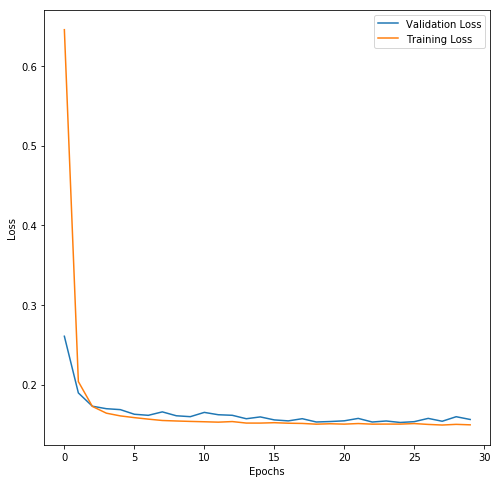

In [75]:
plot_loss(history1)

#### Not Normalized

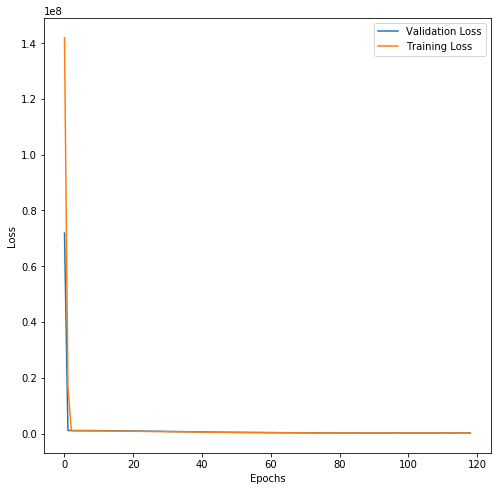

In [67]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

#### Not Normalized

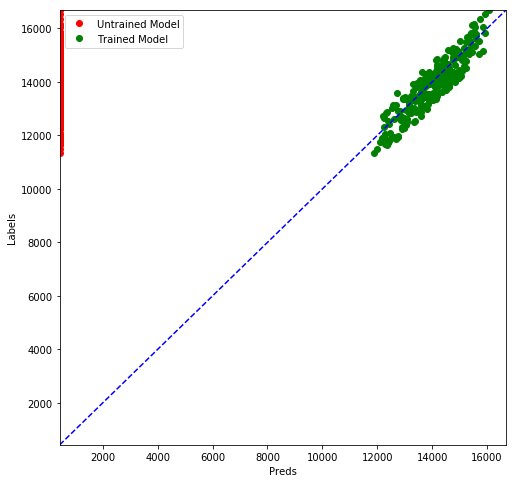

In [68]:
pred=model.predict(xtest)
compare_predictions(predi,pred,ytest)

#### Normalized

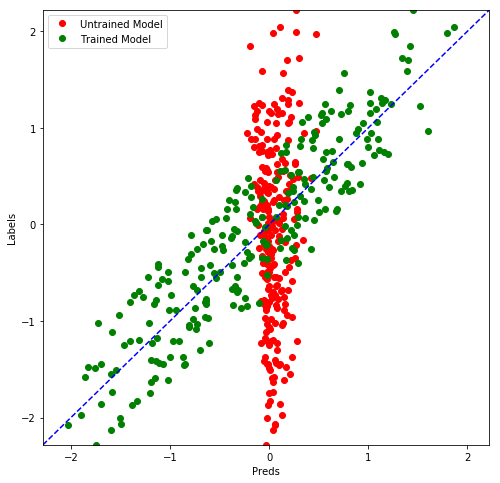

In [76]:
predn=modeln.predict(xtestn)
compare_predictions(predin,predn,ytestn)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

#### Normalized

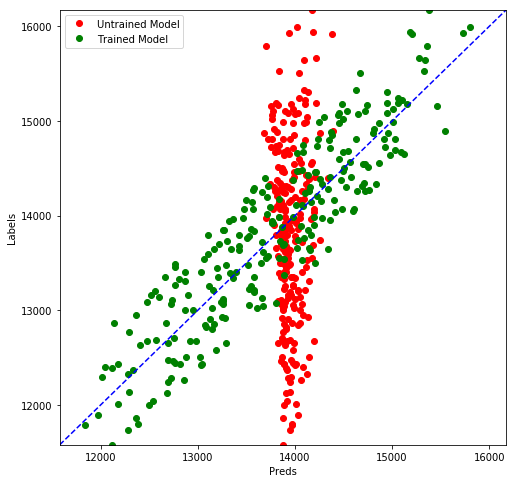

In [77]:
pricein=[convert_label_value(y) for y in predin]
pricen=[convert_label_value(y) for y in predn]

y_testn=[convert_label_value(y) for y in ytestn]
compare_predictions(pricein,pricen,y_testn)